## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")

## Choose PUMS and Preprocess

In [3]:
# Variables for testing; filter to cols and drop na vars
pums_data = p_df[['AGEP','COW','JWMNP','MAR','SCHL','SEX','PINCP']]
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=359075 pre-cleaning
Dataset n=152416 post-cleaning


In [4]:
# This cell removed; used sparse categorical loss to avoid OHE
# Split categorical data into OHE binary vars
cow_dummies = pd.get_dummies(pums_data['COW'], prefix='COW')
mar_dummies = pd.get_dummies(pums_data['MAR'], prefix='MAR')
sex_dummies = pd.get_dummies(pums_data['SEX'], prefix='SEX')
pums_data_numeric = pums_data[['AGEP','JWMNP','SCHL','PINCP']]
num_var_numeric = len(pums_data_numeric.columns)

# Data after encoding
model_data_df = pd.concat([pums_data_numeric, cow_dummies, mar_dummies, sex_dummies], axis=1)
model_data_df = pd.concat([pums_data_numeric, cow_dummies], axis=1)
model_data_df

,AGEP,JWMNP,SCHL,PINCP,COW_1.0,COW_2.0,COW_3.0,COW_4.0,COW_5.0,COW_6.0,COW_7.0,COW_8.0
4,52,70.0,21.0,160000.0,1,0,0,0,0,0,0,0
5,51,20.0,21.0,50000.0,0,0,1,0,0,0,0,0
7,59,30.0,19.0,26710.0,0,0,1,0,0,0,0,0
8,56,15.0,16.0,23600.0,1,0,0,0,0,0,0,0
9,40,5.0,5.0,10000.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
359058,21,4.0,19.0,2700.0,1,0,0,0,0,0,0,0
359065,21,90.0,14.0,8200.0,1,0,0,0,0,0,0,0
359070,22,35.0,16.0,37200.0,0,0,0,0,1,0,0,0
359071,19,7.0,18.0,5300.0,1,0,0,0,0,0,0,0


In [5]:
# Standardize the input data from -1 to 1
scaler = skpre.StandardScaler()
model_data = model_data_df.values
model_data[:,:num_var_numeric] = scaler.fit_transform(model_data[:,:num_var_numeric])

# Remove rows with outliers (3 < standard deviations)
outlier_row_indices = np.where(np.any(model_data[:,:num_var_numeric] > 3, axis=1))
model_data = np.delete(model_data, (outlier_row_indices), axis=0)

# Separate into train/test data
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

## Set Model and Parameters

In [6]:
# Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.0001
rho = 0.9
latent_dim = 4
manifest_dim = model_data.shape[1]
hidden_dim = 50

#TODO:
#Find way to test similarity of joint distributions at end
#Test speeds for sampling new people
#Adjust code for many categorical variables
#Disentangled VAE
#Build a GAN
#Test household/person combinations
#Test new combinations of hyperparameters

In [7]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [8]:
# Encoder
encoder_inputs = keras.Input(shape=(manifest_dim,), name="inputlayer")
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer1")(encoder_inputs)
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer2")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputlayer (InputLayer)         [(None, 12)]         0                                            
__________________________________________________________________________________________________
denselayer1 (Dense)             (None, 50)           650         inputlayer[0][0]                 
__________________________________________________________________________________________________
denselayer2 (Dense)             (None, 50)           2550        denselayer1[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            204         denselayer2[0][0]                
____________________________________________________________________________________________

In [9]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,),name="inputlayer")
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer1")(latent_inputs)
x = layers.Dense(hidden_dim, activation="tanh", name="denselayer2")(x)
decoder_outputs = layers.Dense(manifest_dim, activation="linear", name="outputs")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (InputLayer)      [(None, 4)]               0         
_________________________________________________________________
denselayer1 (Dense)          (None, 50)                250       
_________________________________________________________________
denselayer2 (Dense)          (None, 50)                2550      
_________________________________________________________________
outputs (Dense)              (None, 12)                612       
Total params: 3,412
Trainable params: 3,412
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(x, reconstruction, num_var_numeric):
    data_num = x[:,:num_var_numeric]
    data_cat = x[:,num_var_numeric:]
    reconstruction_num = reconstruction[:,:num_var_numeric]
    reconstruction_cat = reconstruction[:,num_var_numeric:]
            
    # Mean squared error for numerical variables
    reconstruction_loss_numerical = keras.losses.mean_squared_error(data_num, reconstruction_num)
    reconstruction_loss_numerical = tf.reduce_mean(reconstruction_loss_numerical)
    
    # Categorical cross entropy for categorical variables
    reconstruction_loss_categorical = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=True)
    reconstruction_loss_categorical = tf.reduce_mean(reconstruction_loss_categorical)

    return (reconstruction_loss_numerical, reconstruction_loss_categorical)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    
    return kl_loss

In [11]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, num_var_numeric, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.num_var_numeric = num_var_numeric

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            
            # Get loss between input values and sampled from decoder
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(data, reconstruction, self.num_var_numeric)
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat) / 2
            reconstruction_loss *= 4

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = tf.reduce_mean(kl_loss) * -0.5
            
            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss
        
        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Record the loss metrics
        loss_tracker.update_state(total_loss)
        
        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed
    
    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [12]:
# Train
vae = VAE(encoder, decoder, num_var_numeric)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho))
history = vae.fit(train_data, epochs=epochs, batch_size=batch_size)

Epoch 1/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 3.5913 - reconstruction_loss: 2.0206 - reconstruction_loss_num: 0.3766 - reconstruction_loss_cat: 0.6337 - kl_loss: 0.5133
Epoch 2/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 1.4230 - reconstruction_loss: 0.7285 - reconstruction_loss_num: 0.2672 - reconstruction_loss_cat: 0.0970 - kl_loss: 0.6100
Epoch 3/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 1.1871 - reconstruction_loss: 0.5533 - reconstruction_loss_num: 0.2299 - reconstruction_loss_cat: 0.0468 - kl_loss: 0.6068
Epoch 4/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 1.1031 - reconstruction_loss: 0.4924 - reconstruction_loss_num: 0.2124 - reconstruction_loss_cat: 0.0338 - kl_loss: 0.6030
Epoch 5/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 1.0679 - reconstruction_loss: 0.4602 - reconstruction_loss_num: 0.2014 - reconstruction_loss_cat: 

2068/2068 [==============================] - 3s 1ms/step - total_loss: 0.8854 - reconstruction_loss: 0.2748 - reconstruction_loss_num: 0.1283 - reconstruction_loss_cat: 0.0091 - kl_loss: 0.6109
Epoch 41/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 0.8876 - reconstruction_loss: 0.2751 - reconstruction_loss_num: 0.1279 - reconstruction_loss_cat: 0.0096 - kl_loss: 0.6113
Epoch 42/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 0.8860 - reconstruction_loss: 0.2739 - reconstruction_loss_num: 0.1276 - reconstruction_loss_cat: 0.0094 - kl_loss: 0.6115
Epoch 43/50
2068/2068 [==============================] - 3s 2ms/step - total_loss: 0.8860 - reconstruction_loss: 0.2744 - reconstruction_loss_num: 0.1277 - reconstruction_loss_cat: 0.0095 - kl_loss: 0.6103
Epoch 44/50
2068/2068 [==============================] - 3s 1ms/step - total_loss: 0.8809 - reconstruction_loss: 0.2737 - reconstruction_loss_num: 0.1275 - reconstruction_loss_cat: 0.0094 

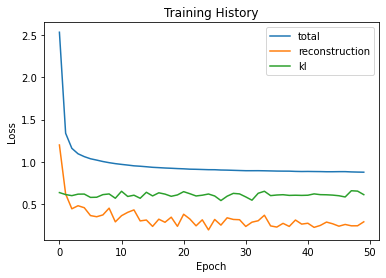

In [13]:
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","reconstruction","kl"], loc="upper right")
plt.show()

## Testing

In [14]:
# Verify that the latent variables follow N[0,1] distribution
z_mean, z_logvar, z = encoder.predict(test_data)

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, latent_dim):
    avg_mean = np.mean(z_mean[:,i])
    avg_logvar = np.mean(z_logvar[:,i])
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_logvar)}\n")

Latent Variable: 0
Mean: 0.046644341200590134
Variance: 0.12707476317882538

Latent Variable: 1
Mean: -0.006400286685675383
Variance: 0.20719993114471436

Latent Variable: 2
Mean: -0.010860586538910866
Variance: 0.32774674892425537

Latent Variable: 3
Mean: -0.02105669304728508
Variance: 0.1940477043390274



In [15]:
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, num_var_numeric)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.129708930850029
Categorical Variable Loss: 0.008359785191714764


In [16]:
# Draw predictions from test data
results = vae.predict(test_data)

# Transform results back to real variable values
results[:,:num_var_numeric] = scaler.inverse_transform(results[:,:num_var_numeric])
results_df = pd.DataFrame(results)
results_df.columns = model_data_df.columns

# Scale test data numerical values
test_data_results = test_data
test_data_results[:,:num_var_numeric] = scaler.inverse_transform(test_data_results[:,:num_var_numeric])
test_data_df = pd.DataFrame(test_data_results)
test_data_df.columns = model_data_df.columns

# Reconstruct the categorical variables from their one hot encoding
results_df['COW'] = results_df.iloc[:,4:11].apply(np.argmax, axis=1)
test_data_df['COW'] = test_data_df.iloc[:,4:11].apply(np.argmax, axis=1)

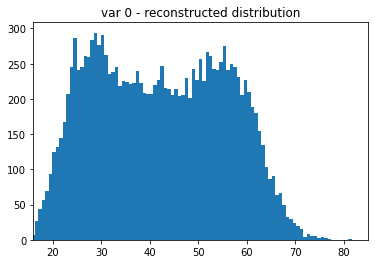

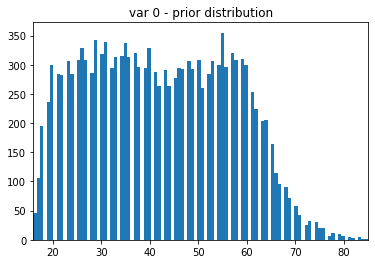

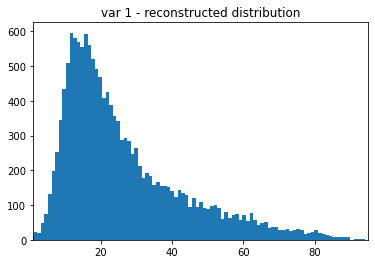

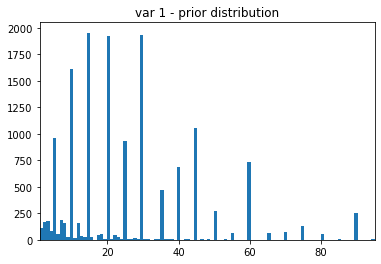

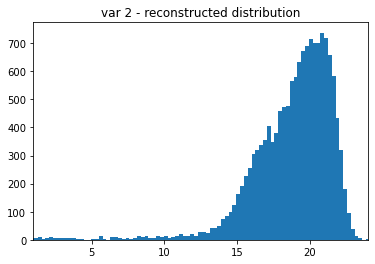

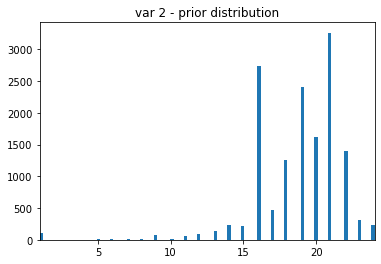

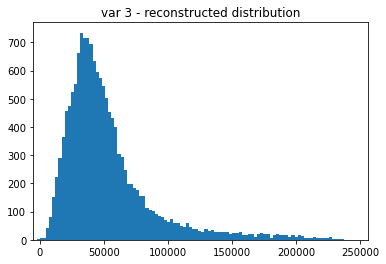

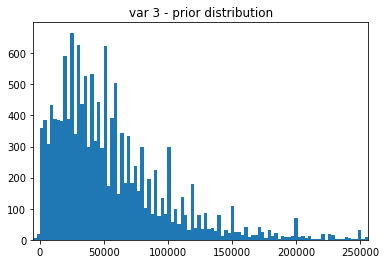

In [17]:
# Show distributions of the resulting variables
for col_idx in range(0, num_var_numeric):
    plt.hist(results[:,col_idx], bins=100)
    plt.xlim(min(test_data_results[:,col_idx]),max(test_data_results[:,col_idx]))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    plt.hist(test_data_results[:,col_idx], bins=100)
    plt.xlim(min(test_data_results[:,col_idx]),max(test_data_results[:,col_idx]))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()